## Личный опыт
1. Концепция MVP (Minimal Viable Product) из продуктовой разработки. Полное понимание алгоритмов, методов, особенностей работы всего скрипта работы с НС сперва на небольших моделях и небольших (учебных) данных. Большие модели + большие выборки = большой риск: много вариантов что может пойти не так + цена ошибки заметно выше.
2. Принцип серии вычислительных экспериментов: одно изменение за раз: не менять сразу несколько парамеров для следующего запуска - вы не поймете что именно привнесло изменения. Лучше каждое изменение фиксировать + фикисровать резльтат последующего эксперимента.
3. После некоторого опыта работы можно определить рутинные операции - и автоматизировать их своими же инструментами (python для этого отлично подходит). Например функции автоматизации промежуточных вычислений, функции-помошники в процессе (загрузчики данных, преобразователи данных, визаулизаторы результатов и т.д.). Часто подобные инструменты уже есть в составе pytorch - вам остается протянуть руку в виде **dir()** или поиска по документации!

# Этапы обучения модели. Практические рекомендации.

**Основные этапы обучения модели:**
1. Постановка задачи
2. Выбор архитектуры НС (создание с нуля или модифицирование готовой), 
3. Аудит, обработка, подготовка (аугментация) данных, 
3. Сам процесс обучения,
5. Оценка результатов

## 1. Постановка задачи
Типовые задачи компьютерного зрения для в домене БАС:
- классификация изображений (присовение метки класса целому изображению)
- обнаружение объектов (локализация на изображении в пределах ограничивающей рамки - bounding box + классификация)
- сегементация объектов или фона (локализация на изображении в пределах попиксельного контура-маски - segmentation mask + классификация)
- отслеживание объектов по видео (tracking - для каждого объекта относительные координаты на каждом кадре + классификация)

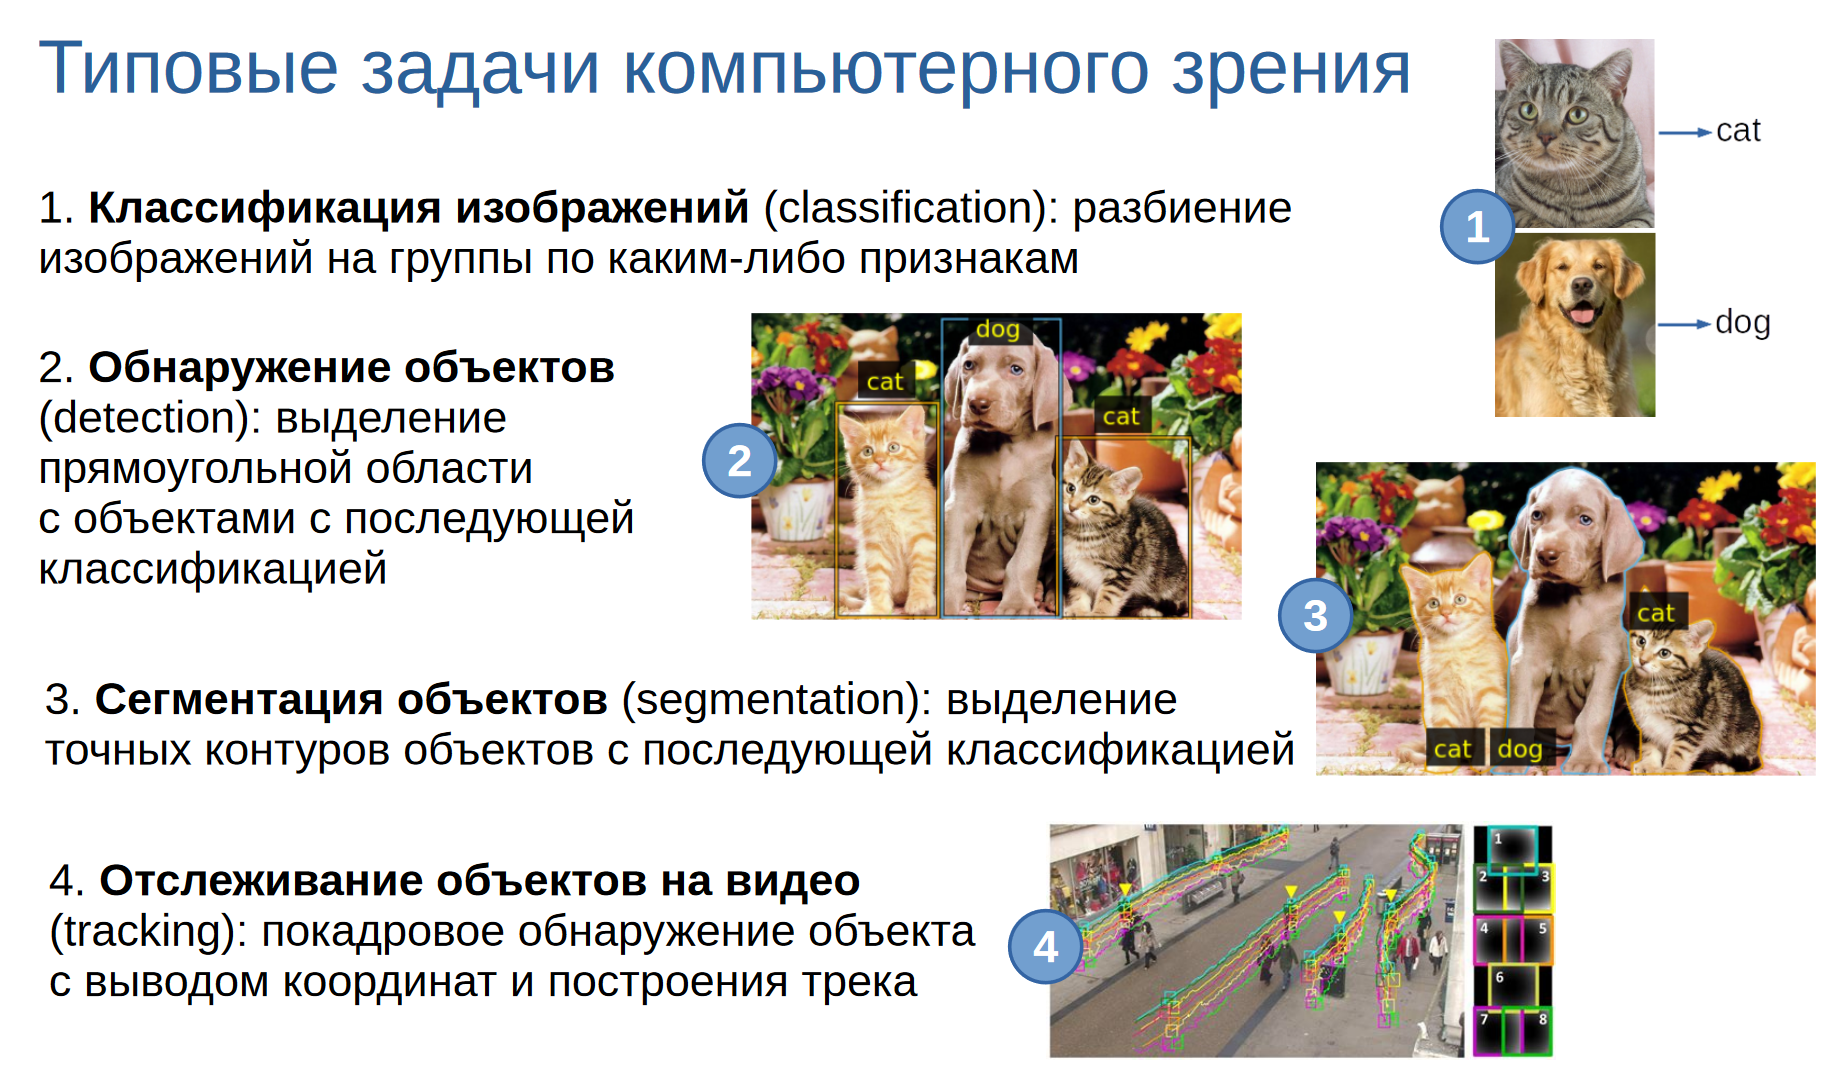

### *Наша задача - мультиклассовая классификация (> 2 классов)*

## 2. Выбор архитектуры НС

Создаем не очень глубокую (до ~ 7 сверточных блоков) НС. Что важно учитывать при создании архитектуры:
- Правило соответствия размерностей тензоров и принимающих слоев - с учетом преобразований в предыдущем слое (которые зависят от парамеров слоя). Подбор параметров слоев с учетом передачи на следующий слой.
- Параметры сверточных слоев: не стоит брать значения >7 для `kernel size`, >2 для `padding`, `stride`. Число фильтров от слоя к слою обычно повышается, но не резко (часто в два раза) - например 3 --> 6 --> 12 --> 18. Вызов класса слоя без параметров даст ошибку - по ней можно понять какие параметры явдляются строго необходимыми (есть еще необязательные - значения установлены по умолчнию, например `stride=1`)
- Число сверточных блоков - до 7-10 (чем их больше - тем дольше обучение и меньше времени на эксперименты). Оптимально - 3-5. Сверточны блок обязательно включает хотя бы один сверточный слой `nn.Conv2d`, слой пулинга - обычно это `nn.MaxPool2d` и слой активации.
- Порядок определенных слоев критичен, но некоторые слои м.б. поменяны местами.

In [1]:
import torch
import numpy as np
import torch.nn as nn
import torchvision
import torch.nn.functional as F
import torchvision.transforms as T
from torchvision import datasets
import matplotlib.pyplot as plt

**Слои из инструментария pytorch, достаточные для выполнения задачи:**
- nn.Linear
- nn.Conv2d
- nn.MaxPool2d
- nn.BatchNorm2d
- nn.ReLU
- nn.Dropout

In [2]:
conv = nn.Conv2d # слой это отдельный класс, котороый можно связать с итменем (сделать переменной)
conv

torch.nn.modules.conv.Conv2d

In [3]:
conv = nn.Conv2d() # по тексту ошибок (случайных или специально вызванных) понятны необходимые пораметры 

TypeError: __init__() missing 3 required positional arguments: 'in_channels', 'out_channels', and 'kernel_size'

In [4]:
?conv 

In [5]:
# Простейшая архитектура CNN с одним сверточным блоком как baseline
class CNN(nn.Module):
    def __init__(self):
        super(CNN, self).__init__()
        self.conv_layer = nn.Sequential(
            nn.Conv2d(1, 32, kernel_size=3),
            nn.ReLU(inplace=True),
            nn.MaxPool2d(2)
        )
        self.fc_layer = nn.Sequential(
            nn.Linear(32 * 15 * 15, 10)
        )
    
    def forward(self, x):
        x = self.conv_layer(x)
        x = x.view(x.size(0), -1)
        x = self.fc_layer(x)
        return x

**Формула свретки**

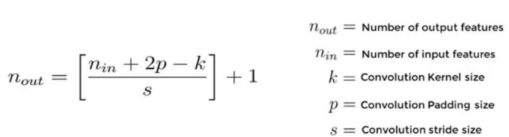

**Из документации pytorch по <a href='https://pytorch.org/docs/stable/generated/torch.nn.Conv2d.html' a>Conv2d:**

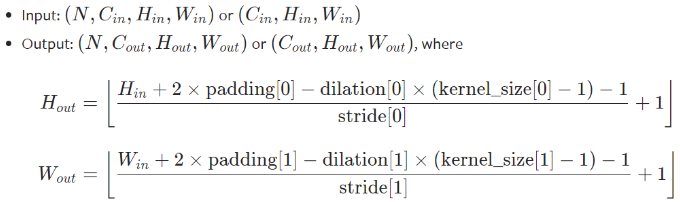

In [6]:
# Инструмент-1: функция расчета формулы свертки

def conv_calc(data, c_out, k, p, d, s):
    
    '''
    Calculate shape for a tensor of dimension (C, H, W)
    forwarded through the conv layer with following paramters:
    k - kernel size [int, int]
    p - padding [int, int]
    d - dilation [int, int]
    s - stride [int, int]
    '''
    h_out = ((data[1] + 2 * p - d[0] * (k[0] - 1) - 1) / s[0]) - 1
    w_out = ((data[2] + 2 * p - d[1] * (k[1] - 1) - 1) / s[1]) - 1
    
    return (c_out, int(h_out), int(w_out))

In [7]:
in_dim = (3, 32, 32) # размерность входного тензора
in_dim

(3, 32, 32)

In [8]:
c_out = 6 # set to 6, in_dim[0] == in channels
k = (3,3) # set "standard" kernel size of 3x3
p = 0 # pytorch default
d = (1,1) # pytorch default
s = (1,1) # pytorch default

out = conv_calc(in_dim, c_out, k, p, d, s)
out

(6, 28, 28)

## 3. Работа с данными
- Загрузка
- Аудит
- Обработка и подготовка 
- Аугментация (дополнительно)

### Загрузка
Pytorch предоставляет удобный базовый <a><a href='https://pytorch.org/docs/stable/data.html#torch.utils.data.DataLoader' a>класс-шаблон</a> `torch.utils.data.DataLoader` для загрузки данных, который может обращаться к датасетам из списка:

In [9]:
print(dir(torchvision.datasets)) # all datasets list

['CIFAR10', 'CIFAR100', 'CLEVRClassification', 'CREStereo', 'Caltech101', 'Caltech256', 'CarlaStereo', 'CelebA', 'Cityscapes', 'CocoCaptions', 'CocoDetection', 'Country211', 'DTD', 'DatasetFolder', 'EMNIST', 'ETH3DStereo', 'EuroSAT', 'FER2013', 'FGVCAircraft', 'FakeData', 'FallingThingsStereo', 'FashionMNIST', 'Flickr30k', 'Flickr8k', 'Flowers102', 'FlyingChairs', 'FlyingThings3D', 'Food101', 'GTSRB', 'HD1K', 'HMDB51', 'INaturalist', 'ImageFolder', 'ImageNet', 'Imagenette', 'InStereo2k', 'KMNIST', 'Kinetics', 'Kitti', 'Kitti2012Stereo', 'Kitti2015Stereo', 'KittiFlow', 'LFWPairs', 'LFWPeople', 'LSUN', 'LSUNClass', 'MNIST', 'Middlebury2014Stereo', 'MovingMNIST', 'Omniglot', 'OxfordIIITPet', 'PCAM', 'PhotoTour', 'Places365', 'QMNIST', 'RenderedSST2', 'SBDataset', 'SBU', 'SEMEION', 'STL10', 'SUN397', 'SVHN', 'SceneFlowStereo', 'Sintel', 'SintelStereo', 'StanfordCars', 'UCF101', 'USPS', 'VOCDetection', 'VOCSegmentation', 'VisionDataset', 'WIDERFace', '__all__', '__builtins__', '__cached__',

При создании <a><a href='https://pytorch.org/tutorials/beginner/basics/quickstart_tutorial.html#working-with-data' a>датасета</a> указывается:
- корневая директория для загрузки датасета
- флаг train / validation для создания обучающей или проверочно выборок
- загружать ли данные (True / False)
- список трансформаций (обязательная: перевод изображения в тензорную форму)
- и другие (докуменитация по ссылке)

**Гиперпараметры, определяемые на стадии загрузки данных и созадения загрузчиков:**

In [10]:
trans = T.ToTensor() # transformation set
bs = 8 # batch size
num_w = 2 # num of CPU threads to load data

In [11]:
my_dataset = torchvision.datasets.MNIST(root='./data', train=True,
                                        download=True, transform=trans)

Загрузчик <a><a href='https://pytorch.org/docs/stable/data.html#torch.utils.data.DataLoader' a>DataLoader</a> принимает объект `dataset` и другие параметры:
- размер батча
- флаг перемешивания выборки
- число потоков процессора для загрузки данных 
- и другие (докуменитация по ссылке)

In [12]:
my_loader = torch.utils.data.DataLoader(my_dataset, batch_size=bs,
                                          shuffle=True, num_workers=num_w)

На данном этапе нужно:
- Найти рабочий датасет (три на выбор: MNIST, FashionMNIST, CIFAR-10), загрузить в его в соответсвующий объект dataset
- Создать два объекта-датасета: для обучения и для проверки
- Создать на основе полученных датасетов два соответствующих загрузчика
- Желательно визуализировать батч данных для понмиания особенностей изображений

Краткие примеры в pytorch по <a href='https://pytorch.org/tutorials/beginner/basics/data_tutorial.html' a>datasets и dataloaders

### Аудит

- Визуальная оценка - обзор: визуально близкие классы, зашумленные классы, дубликаты, выбросы, ошибки в разметке, систематические смещения
- Объем выборки, число примеров каждого класса, баланс классов
- Характеристики изображений: число каналов, разрешение, качество, размер объектов, шумы.
- Визуально далекие классы + крупный размер объектов + хорошее разрешение: можно ли уменьшить размер изображений без потери качества классификации?

### Обработка и подготовка
Реальные датасеты - реальные проблемы, которые нужно решать:
- Очистка: удаление дубликатов, поврежденны или посторонних изоражений (и меток классов).
- Перемешивание: для устранения упорядоченности в данных (может присутствовать по рзнам причинам: привычка разметчика, выгрузка данных с иетками классов в алфавитно порядке и др.)
- Разделение данных на обучающую и проверочную выборки (обычно это 80% и 20% соответственно). Иногда: делят на train (70%), validation (20%) и test (10%)
- Нормализация: из каждого элемента жанных вычитается среденее, результат делится на ст. отклонение

Предложенные в задании MNIST, FashionMNIST и CIFAR-10 - учебные датасеты, с данными все в порядке (очищены от выбросов, дубликатов, проверены метки классов, хороший баланс классов и т.д.)

**Визуализация: пример**

In [13]:
classes = [str(i) for i in range(0,10)]
classes

['0', '1', '2', '3', '4', '5', '6', '7', '8', '9']

In [ ]:
# Инструмент-2: функция визуализации данных
classes = [str(i) for i in range(0,10)]

def imshow(img):
    img = img / 2 + 0.5 # денормализуем
    npimg = img.numpy() # перевод в массив numpy
    plt.imshow(np.transpose(npimg, (1, 2, 0))) # замена местами размерностей: C,H,W --> H,W,C (matplotlib ожидает именно так) 
    plt.show()

dataiter = iter(my_loader) # итератор на основе загрузчика
images, labels = next(dataiter) # метод next - вызвать следующий объект итератора

imshow(torchvision.utils.make_grid(images))
print(' '.join(f'{classes[labels[j]]:5s}' for j in range(bs))) # bs = batch size (см выше)

**Нормализация данных**

In [32]:
# Инструмент-3: функция вычисления среднего и станадртного отклонения для 1-канального и 3-канального изображений
def get_mean_std_train_data(data_root):
    
#     train_trans = T.Compose([T.ToTensor()]) это лишний параметр - он не влияет на расчеты, тут не нужен
    train_set = datasets.CIFAR10(root=data_root, train=True, download=True) # тут параметр transforms можно опустить
    '''Вместо CIFAR10 можно подставить MNIST, FashioMNIST или другой датасет из trochvision.datasets,
    поменяв также data_root на другую директорию: тогда другой датасет загрузится туда. Потом из ноутбука к нему
    удобно обращаться для подгрузки'''
    
    if len(train_set.data.shape) > 3:
        r_mean = train_set.data[...,0].mean()/255 # каналы в последнем измерении
        r_std = train_set.data[...,0].std()/255
        g_mean = train_set.data[...,1].mean()/255
        g_std = train_set.data[...,1].std()/255
        b_mean = train_set.data[...,2].mean()/255
        b_std = train_set.data[...,2].std()/255

        mean = np.array([r_mean, g_mean, b_mean])
        std = np.array([r_std, g_std, b_std])

    else:
        mean = train_set.data.float().mean()/255
        std = train_set.data.float().std()/255
    
    return mean, std

tensor(0.1307) tensor(0.3081)


Вместо `'./data_2'` вставьте свою директорию, ту же где ноутбук со скриптом:

### Аугментация (дополнительный шаг)
Смысл аугментации - увеличить объем и разнообразие обучающей выборки за счет добавки несколько измененных копий элементов, что при обучении дает возможность НС увеличить генерализующую способность, т.е. меньше переобучаться. Рекомендуется начинать эксперименты с аугментацией только посдле увреренного освоения и реализации baseline. Принципы аугментации:
- Обычно аугментируется только обучающая выборка
- Аугментаций не должно быть слишком много (серия из 3-5 преобразрований)
- Аугментации не должны быть слишком "жесткими" (сильные искажения изображений по цвету, геометрии, сильные шумы и т.д.)

В pytorch аугментации собраны в `torchvision.transforms` (здесь ку ним можно обращаться по псевдониму `Т` из импорта выше, например `T.ToTensor()` и т.д.). <a href='https://pytorch.org/vision/stable/transforms.html[' a>Краткое руководство (V2).
    
Перед применением полезно еще раз просмотреть обучающую и проверочную выборки и подумать: какие аугментации будут осмыслены с т.зр. задачи? Какие могут быть вредны?

In [35]:
common_trans = T.Compose([
    T.ToTensor(),
    T.Normalize(mean, std) # <-- сюда подставляем данные среднего и ст. отклонения для все выборки
    ])

train_trans = T.Compose([
    common_trans,
    # custom transforms
    T.RandomHorizontalFlip(p=0.3),
    T.RandomCrop(size=24, padding=2),
    T.ColorJitter(brightness=0.1, contrast=0.2, saturation=0.1, hue=0.1)
    ])

In [36]:
train_trans # объекты Compose можно вкладывать друг в друга

Compose(
    Compose(
    ToTensor()
    Normalize(mean=0.13066047430038452, std=0.30810779333114624)
)
    RandomHorizontalFlip(p=0.3)
    RandomCrop(size=(24, 24), padding=2)
    ColorJitter(brightness=(0.9, 1.1), contrast=(0.8, 1.2), saturation=(0.9, 1.1), hue=(-0.1, 0.1))
)

## 4. Процесс обучения

**Общая схема этапов обучения НС. Начало экспериментов - максимально упростить схему!** 
- Максимально простая модель (т.н. baseline)
- Не использовать аугментации
- Не играться с парметрами optimizer, Adam с настройками по умолчанию - хорошая точка для старта
- Фиксируем random seed и другие источники случайности

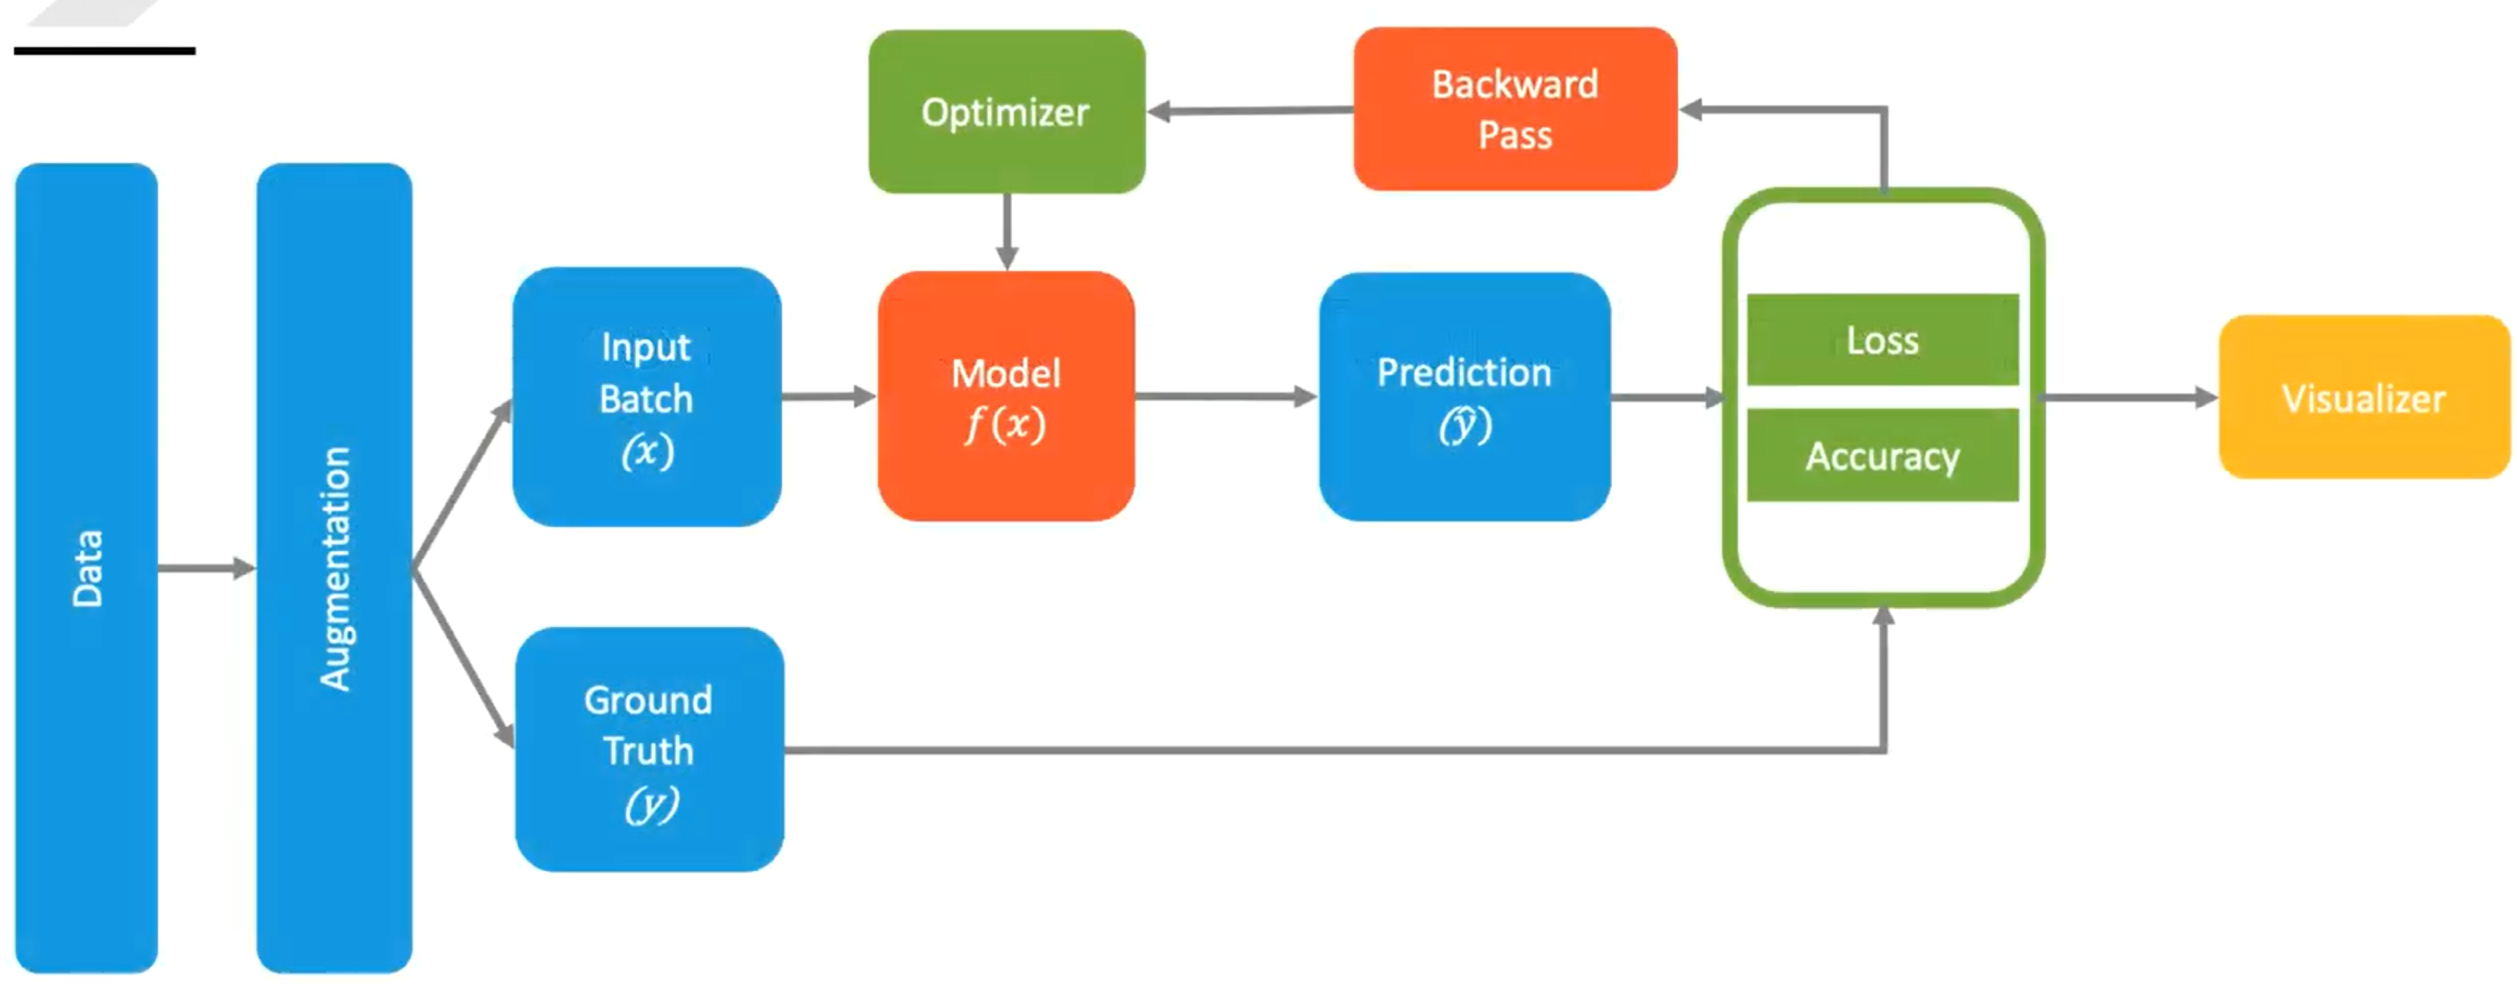


In [ ]:
seed = 34
torch.manual_seed(seed) # фиксация "случайного зерна" констатой - для воспроизводимости результата

if torch.cuda.is_available(): # тоже, для счастливых обладателей GPU
    torch.backends.cudnn_benchmark_enabled = True
    torch.backends.cudnn.deterministic = True

**Рекомендуемые шаги:**
- Полезно визуализировать несклько батчей данных перед тем как запускать обучение
- Проверяем весь pipeline: без агументации, берем простую модель (baseline) - запускаем с ней, получаем быстрый результат. Все ли работает корректно?
- Начинать настройку гиперпараметров c lerning rate (LR) : в параметрах Adam отключить weight decay (проверить!), по умолчанию взять от 0.0001 до 0.001. Если train loss падает - модель учится
- <b>Cross entropy loss</b>: изначальное значение д.б. log(N), для <b>accuracy</b> оно д.б. 1/N, где N - число классов
- Запуск обучения на 3-4 эпохи - убеждаемся что модель обучается (train loss падает, train accuracy растет)
- Обучение на единственном батче - если НЕ достигает быстро (2-3 эпохи) 100% train accuracy - можно усложнить модель (добавить сверточных блоков) и снова попробовать

**ВАЖНО:** train loss в процессе обучения считается по отдельным батчам (далее может усредняться за все обучение), а validation loss считатется по ВСЕЙ проверочной выборке

### Эффект переобучения (overfitting)

Компромисс смещенности и разброса (bias VS variance tradeoff): баланс между недообученной и переобученной (но плохо генерализующей) моделью. Модель м.б. слишком сложна для какого-то небольшого набора данных и тогда она просто его "запоминает" (идеально работает на нем... но только на нем). Технически верный признак переобучения - loss на при обучении (т.е. training loss) падает, а на проверке (т.е. validation/test loss) - растет. Соответственно, train accuracy растет, validation/test - падает. Важно отслеживать динамику этих показателей в процессе обучения!

- Недостаточное обучение (underfitting): high bias
- Переобучение (overfitting): high variance
- Генерализующая сопосбность (generalization): способность модели обобщать информацию из обуения для верного выполненния задачи на подобных объектах, на которых она не обучалась ("не видела").

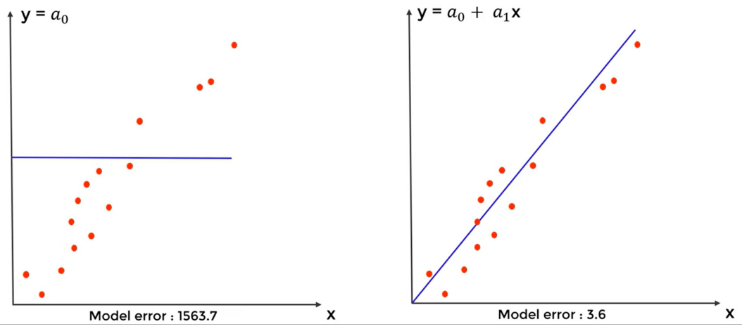

Пример с простой задачей - подбора лучшей модели (по критерию MSE), описывающей данные: слева - линия-константа, справа, линейная модель (более сложная - но и намного более точная).

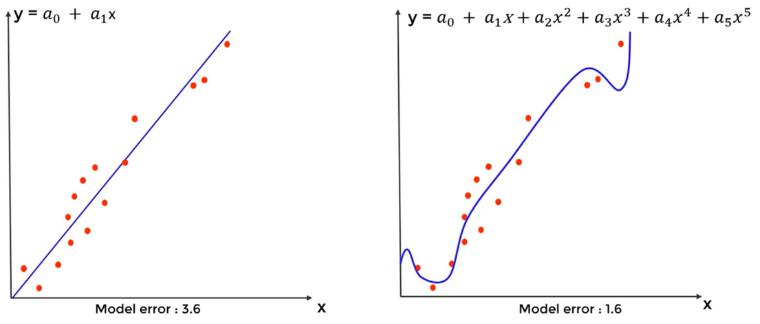

Еще более сложная модель: полином 5-й степени. Еще точнее (MSE меньше), но... как она поведет себя на проверочной выборке, на которой не имела возможности обучаться?

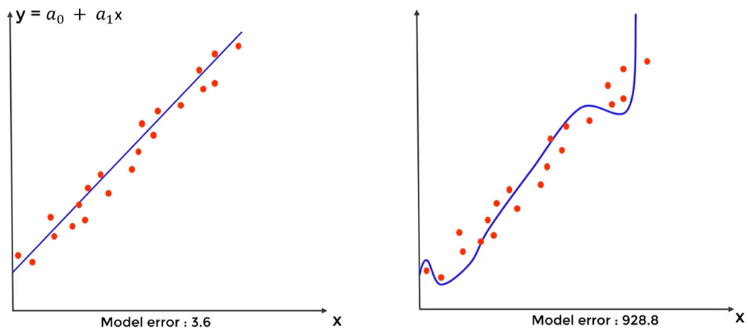

Слишком плотное и жесткое следование за всеми деталями обучающей выборки - и есть переобучение! Этой модели не хватает гибкости (генерализующей сопосбоности).

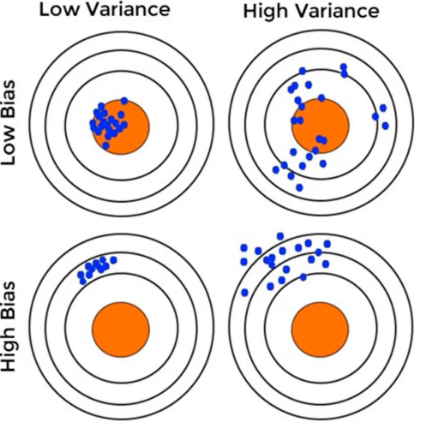

Общая ошибка модели: **bias + variance + irreducible error** (т.к. любые реальные данные содержат шум и ошибки). Сначала модель должна научиться - и возможно, переобучиться. Далее уже для переобученной модели применяются техники борьбы с переобучением (методы регуляризации).

- Прогнать сеть на всей обучающей выборке (отключив все техники борьбы с переобучением). Получилоь переобучиться? Если нет - можно усложнить архитектуру НС.
- Сделать предсказания и визуализировать предсказания в виде изображений и меток классов (рекомендуется после каждых 2-3 эпох обучения).

**Как выглядит переобучение на графиках?**
- при обучении loss падает, а при проверке - с какого-то момента начинает расти,
- при обучении accuracy падает, а при проверке - с какого-то момента стагнирует примерно на одном уровне

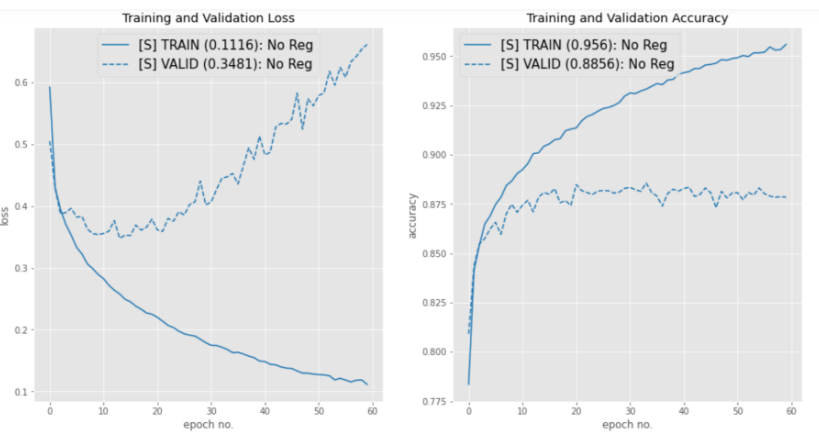

### Борьба с переобучением (регулияризация)
- Больше данных (собрать, сделать аугментации, синтетические данные)
- Добавить BatchNorm и Dropout слои (лучше что-то одно, хотя бы начинать с чего-то одного).
- Добавить регуляризацию в функцию потерь (L1, L2, MaxNorm).
- Включить weight decay для Adam
- Останавливать обучение раньше (смотреть по динамике train VS test loss).

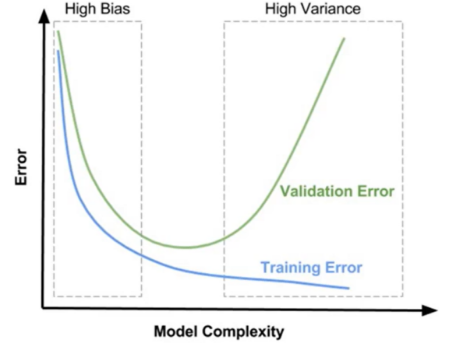

Задача: подобрать модель **оптимальной сложности** (слишком простая: high bias, слишком сложная: high variance)

## Аттестационное задание: что брать за основу?
1. Ноутбук по лекции "Современные архитектуры сетей для работы с изображениями"
2. Полная инструкция по работе в pytorch с <a href='https://pytorch.org/tutorials/beginner/blitz/cifar10_tutorial.html' a> простым сверточным классификатором на CIFAR-10